In [1]:
import pandas
import konlpy
import gensim
import matplotlib.pyplot as plt

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('./sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('./sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import tensorflow as tf
import os

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3
index_to_word = {index: word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공

In [6]:
# 3)-1 데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))


# 3)-2 적절한 최대 문장 길이 지정
# 최대 문장길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')




문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
from tensorflow.keras.preprocessing.sequence import pad_sequences

# pad_sequences를 활용한 패딩 추가
def pad_text_data(X_train, X_test, maxlen):
    # 패딩 추가 (뒤쪽을 0으로 패딩)
    X_train_padded = pad_sequences(X_train, value=word_to_index["<PAD>"], maxlen=maxlen, padding='post')
    X_test_padded = pad_sequences(X_test, value=word_to_index["<PAD>"], maxlen=maxlen, padding='post')
    return X_train_padded, X_test_padded

# 패딩 적용
X_train, X_test = pad_text_data(X_train, X_test, maxlen)

# 결과 확인
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Example X_train:", X_train[0])

X_train shape: (146182, 41)
X_test shape: (49157, 41)
Example X_train: [ 32  74 919   4   4  39 228  20  33 748   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]


### 4) 모델 구성 및 validation set 구성

In [8]:
# validation set 구성
import numpy as np

# validation set 10,000건 분리
X_val = np.array(X_train[:10000])
y_val = np.array(y_train[:10000])

# validation set을 제외한 나머지 15,000건
partial_X_train = np.array(X_train[10000:])
partial_y_train = np.array(y_train[10000:])

# 데이터의 shape 출력
print(partial_X_train.shape)  # (15000, sequence_length)
print(partial_y_train.shape)  # (15000,)

(136182, 41)
(136182,)


### 4)-1 1D-CNN

In [9]:
import tensorflow as tf

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계
model1 = tf.keras.Sequential([
    # Embedding 레이어
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_shape=(None,)),

    # Conv1D 레이어와 MaxPooling1D
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),

    # 추가 Conv1D 레이어
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),  # 전체 시퀀스에서 가장 큰 값을 선택

    # Dense layer
    tf.keras.layers.Dense(8, activation='relu'), #은닉층
    tf.keras.layers.Dense(1, activation='sigmoid') #출력층: 긍정1, 부정0
])
#모델 요약
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          8016      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1296      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [10]:
# 모델 컴파일
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=10 # epochs=100

history1 = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 35s 7ms/step - loss: 0.4381 - accuracy: 0.7981 - val_loss: 0.3390 - val_accuracy: 0.8498
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3115 - accuracy: 0.8677 - val_loss: 0.3322 - val_accuracy: 0.8572
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2730 - accuracy: 0.8880 - val_loss: 0.3386 - val_accuracy: 0.8529
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2346 - accuracy: 0.9074 - val_loss: 0.3531 - val_accuracy: 0.8524
Epoch 5/10
266/266 [==============================] - 1s 5ms/step - loss: 0.1939 - accuracy: 0.9268 - val_loss: 0.3822 - val_accuracy: 0.8476
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.1541 - accuracy: 0.9449 - val_loss: 0.4305 - val_accuracy: 0.8450
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.1191 - accuracy: 0.9593 - val_loss: 0.4790 - val_accuracy: 0.8410
Epoch

In [11]:
results1 = model1.evaluate(X_test,  y_test, verbose=2)
print(results1)
print(history1.history.keys())  # epoch에 따른 그래프를 그려볼 수 있는 항목들

1537/1537 - 3s - loss: 0.6631 - accuracy: 0.8318
[0.6631224751472473, 0.831763505935669]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


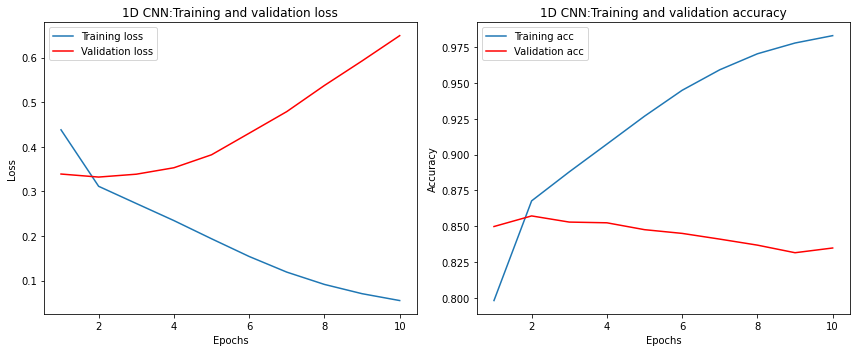

In [12]:
### 그래프
import matplotlib.pyplot as plt

acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

epochs1 = range(1, len(acc1) + 1)

# 서브플롯 생성
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열의 서브플롯 생성, 크기 조정

# 첫 번째 서브플롯: Training and validation loss
axs[0].plot(epochs1, loss1, label='Training loss')
axs[0].plot(epochs1, val_loss1, 'r', label='Validation loss')
axs[0].set_title('1D CNN:Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# 두 번째 서브플롯: Training and validation accuracy
axs[1].plot(epochs1, acc1, label='Training acc')
axs[1].plot(epochs1, val_acc1,'r', label='Validation acc')
axs[1].set_title('1D CNN:Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

### LSTM사용

In [13]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# 모델 설계 - LSTM 기반 모델
model2 = tf.keras.Sequential([
    # Embedding 레이어
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_shape=(None,)),
    
    # LSTM 레이어
    tf.keras.layers.LSTM(16, activation='tanh', return_sequences=False),  # LSTM 레이어
    
    # Dense layer
    tf.keras.layers.Dense(8, activation='relu'),  # 은닉층
    tf.keras.layers.Dense(1, activation='sigmoid')  # 출력층: 긍정1, 부정0
])


#모델 요약
model2.summary()


model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 16)                7488      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,007,633
Trainable params: 1,007,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
266/266 [==============================] - 8s 7ms/step - loss: 0.5094 - accuracy: 0.7379 - val_loss: 0.3597 - val_accuracy: 0.8445
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3367 - accuracy: 0.8566 

In [14]:
# 평가 지표
results2 = model2.evaluate(X_test,  y_test, verbose=2)
print(results2)

1537/1537 - 3s - loss: 0.4275 - accuracy: 0.8453
[0.42749497294425964, 0.8452712893486023]


<Figure size 432x288 with 0 Axes>

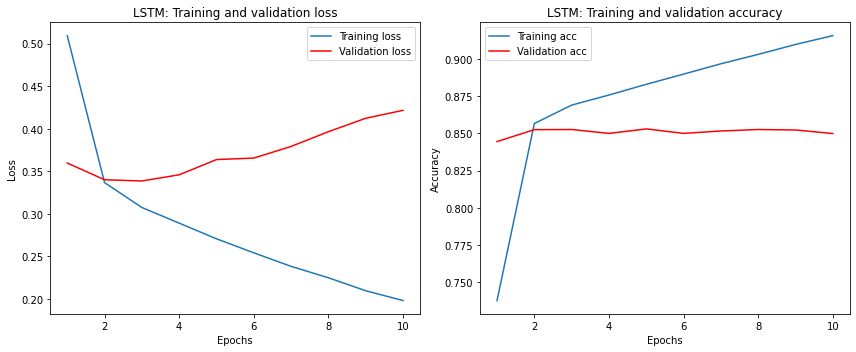

In [15]:
### 그래프 그리기
plt.clf() # 앞서 그린 그래프 지우기
# 데이터 준비
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs2 = range(1, len(acc2) + 1)

# 서브플롯 생성
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열의 서브플롯 생성, 크기 조정

# 첫 번째 서브플롯: Training and validation loss
axs[0].plot(epochs2, loss2, label='Training loss')
axs[0].plot(epochs2, val_loss2, 'r', label='Validation loss')
axs[0].set_title('LSTM: Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# 두 번째 서브플롯: Training and validation accuracy
axs[1].plot(epochs2, acc2, label='Training acc')
axs[1].plot(epochs2, val_acc2, 'r', label='Validation acc')
axs[1].set_title('LSTM: Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

### Transformer 방식

In [16]:
import tensorflow as tf

# 하이퍼파라미터 설정
vocab_size = 10000    # 어휘 사전의 크기입니다 (10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수
num_heads = 4         # Multi-Head Attention의 헤드 수
ffn_dim = 32          # Feed-Forward Network의 은닉층 차원
num_layers = 2        # Transformer 블록의 수

# Positional Encoding
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, maxlen, d_model):
        super().__init__()
        self.pos_encoding = self._positional_encoding(maxlen, d_model)
    
    def _positional_encoding(self, maxlen, d_model):
        positions = tf.range(maxlen, dtype=tf.float32)[:, tf.newaxis]  # (maxlen, 1)
        dimensions = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]  # (1, d_model)

        # angle_rates 계산
        angle_rates = 1 / tf.pow(10000, (2 * (dimensions // 2)) / tf.cast(d_model, tf.float32))
        angle_rads = positions * angle_rates  # (maxlen, d_model)

        # sin과 cos 함수를 적용하여 positional encoding 생성
        pos_encoding = tf.concat([tf.sin(angle_rads), tf.cos(angle_rads)], axis=-1)  # (maxlen, d_model*2)

        # 만약 d_model이 16이 아니라면, pos_encoding의 차원을 d_model에 맞게 조정
        pos_encoding = pos_encoding[:, :d_model]  # (maxlen, d_model)

        return pos_encoding

    def call(self, x):
        # x에 pos_encoding을 더할 때 배치 차원을 고려한 브로드캐스팅
        return x + self.pos_encoding[:tf.shape(x)[1], :]

# Transformer 블록 정의
def transformer_block(inputs, num_heads, ffn_dim, dropout_rate=0.1):
    # Multi-Head Attention
    attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = tf.keras.layers.Dropout(dropout_rate)(attention_output)
    attention_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    # Feed-Forward Network
    ffn_output = tf.keras.layers.Dense(ffn_dim, activation='relu')(attention_output)
    ffn_output = tf.keras.layers.Dense(inputs.shape[-1])(ffn_output)
    ffn_output = tf.keras.layers.Dropout(dropout_rate)(ffn_output)
    output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)
    
    return output

# 모델 설계 - Transformer 기반 모델
inputs = tf.keras.Input(shape=(None,))  # 입력 시퀀스
embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim)(inputs)


# Positional Encoding 추가
maxlen = 41  # 최대 시퀀스 길이
pos_encoding = PositionalEncoding(maxlen, word_vector_dim)(embedding)

x = pos_encoding
for _ in range(num_layers):
    x = transformer_block(x, num_heads=num_heads, ffn_dim=ffn_dim)

# 출력층
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model3 = tf.keras.Model(inputs=inputs, outputs=outputs)

# 모델 요약
model3.summary()


# 모델 컴파일 및 학습
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 학습
history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    1000000     input_1[0][0]                    
__________________________________________________________________________________________________
positional_encoding (Positional (None, None, 100)    0           embedding_2[0][0]                
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, None, 100)    161300      positional_encoding[0][0]        
                                                                 positional_encoding[0][0]    

In [17]:
# 평가 지표
results3 = model3.evaluate(X_test, y_test, verbose=2)
print(results3)

1537/1537 - 6s - loss: 0.4943 - accuracy: 0.8314
[0.49432405829429626, 0.8313973546028137]


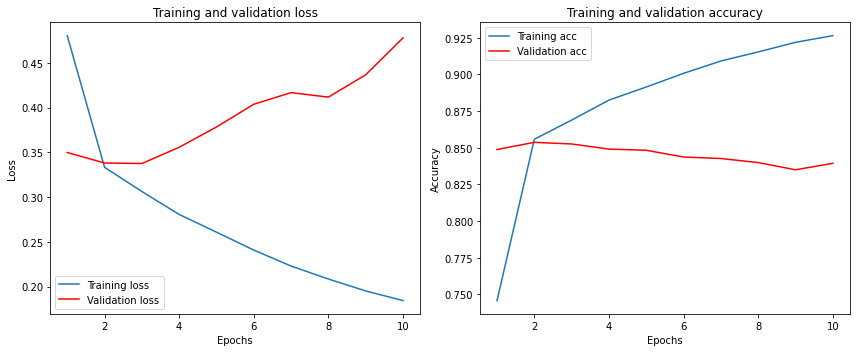

In [18]:
# 그래프 비교 
# 데이터 준비
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

epochs3 = range(1, len(acc3) + 1)

# 서브플롯 생성

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열의 서브플롯 생성, 크기 조정

# 첫 번째 서브플롯: Training and validation loss
axs[0].plot(epochs3, loss3, label='Training loss')
axs[0].plot(epochs3, val_loss3, 'r', label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# 두 번째 서브플롯: Training and validation accuracy
axs[1].plot(epochs3, acc3, label='Training acc')
axs[1].plot(epochs3, val_acc3, 'r', label='Validation acc')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

### 5) 학습된 임베딩 레이어 분석

In [41]:
!mkdir -p ~/aiffel/sentiment_classification/data
!pip list | grep gensim

gensim                        4.1.2


In [42]:
embedding_layer = model1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [43]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = './sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
# 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
vectors = model1.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(
        map(str, list(vectors[i, :])))))
f.close()

### gensim에서 제공하는 패키지를 이용해, 임베딩 파라미터를 word vector로 활용

In [46]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)


# 단어 목록 확인
print(list(word_vectors.key_to_index.keys())[:10])  # 상위 10개 단어 출력

vector = word_vectors['영화']
vector


['.', '영화', '다', '고', '하', '을', '보', '..', '게', ',']


array([ 0.05002201,  0.03934309,  0.03146545,  0.03118193, -0.00207544,
        0.00352426, -0.00527191,  0.04108677, -0.05589182,  0.03689983,
       -0.01024756, -0.0306393 ,  0.03106149, -0.02134071,  0.04343372,
        0.03103324, -0.07128024,  0.06201493,  0.03393487, -0.06090207,
       -0.02940324, -0.05073766,  0.01229669, -0.02518526,  0.02754097,
        0.08497858, -0.01258145,  0.012964  ,  0.01680416,  0.02134122,
        0.06956539,  0.01313277, -0.0075924 , -0.03827441, -0.06578936,
       -0.00142613,  0.04785856, -0.00507611,  0.00586076, -0.03928617,
       -0.00653006, -0.05204676,  0.09191003, -0.0051724 ,  0.05116236,
        0.02009302, -0.0345631 ,  0.02961282,  0.04056694, -0.01311913,
        0.01574338,  0.0276653 ,  0.02276265,  0.04261274, -0.03558856,
       -0.02833935,  0.00148544, -0.06230442, -0.01339812,  0.04279778,
       -0.03757457, -0.0368858 ,  0.00391973, -0.08549125, -0.02250303,
       -0.04447958,  0.03533359,  0.02117806,  0.02199817, -0.01

#### 비슷한 단어 유사도 확인

In [47]:
word_vectors.similar_by_word("영화")

[('종말', 0.5488008856773376),
 ('하울', 0.5158270597457886),
 ('실물', 0.5127533674240112),
 ('국회의원', 0.509310245513916),
 ('안티', 0.5059517621994019),
 ('2004', 0.49522721767425537),
 ('소동', 0.4847966432571411),
 ('11', 0.48158571124076843),
 ('담당', 0.48136335611343384),
 ('내전', 0.470119446516037)]

### 한국어 Word2Vec

In [49]:
# !ln -s ~/data/word2vec_ko.model ~/aiffel/sentiment_classification/data
# !ln -s ~/data/word2vec_ko.model.trainables.syn1neg.npy ~/aiffel/sentiment_classification/data
# !ln -s ~/data//word2vec_ko.model.wv.vectors.npy ~/aiffel/sentiment_classification/data

In [50]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = './sentiment_classification/data/word2vec_ko.model'

word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']
vector.shape

(100,)

In [51]:
word_vectors.wv.similar_by_word("영화")

[('드라마', 0.8418774008750916),
 ('뮤지컬', 0.7775140404701233),
 ('코미디', 0.7489107251167297),
 ('다큐멘터리', 0.7401294708251953),
 ('헐리우드', 0.7397844195365906),
 ('애니메이션', 0.7170552015304565),
 ('독립영화', 0.7113528251647949),
 ('로맨틱', 0.7107657194137573),
 ('장편', 0.7101576924324036),
 ('극영화', 0.7045413255691528)]

##### [비교결과] gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습된 임베딩(한국어 Word2Vec)을 비교하여 보니, 자체 학습된 경우 '영화'라는 단어와 유사단어로 나온 결과가 유사도도 0.5정도이고, '종말','하울','국회의원'등의 단어가 도출되었으나, 사전학습된 임베딩의 경우 '드라마'(0.84), '뮤지컬'(0.77), '코미디'(0.74)등으로 유사도가 높은 단어들이 도출되었다. 다음 단계에서 기존의 임베딩을 Word2Vec임베딩으로 교체하여 모델을 학습시키겠음





In [52]:
# embedding_matrix 크기 설정
vocab_size = 10000
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]
        
        
        
print(embedding_matrix.shape)

(10000, 100)


### 한국어 Word2Vec이 임베딩된 상태에서 1D-CNN으로 모델 학습

In [53]:
### 1d-cnn

from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model4.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model4.add(tf.keras.layers.MaxPooling1D(5))
model4.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model4.add(tf.keras.layers.GlobalMaxPooling1D())
model4.add(tf.keras.layers.Dense(8, activation='relu'))
model4.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [54]:
# 학습의 진행
model4.compile(optimizer = "adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history4 = model4.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 2s 5ms/step - loss: 0.5771 - accuracy: 0.6853 - val_loss: 0.4820 - val_accuracy: 0.7751
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.4408 - accuracy: 0.7966 - val_loss: 0.4166 - val_accuracy: 0.8116
Epoch 3/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3812 - accuracy: 0.8308 - val_loss: 0.3808 - val_accuracy: 0.8272
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3447 - accuracy: 0.8496 - val_loss: 0.3597 - val_accuracy: 0.8379
Epoch 5/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3191 - accuracy: 0.8637 - val_loss: 0.3592 - val_accuracy: 0.8410
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3013 - accuracy: 0.8732 - val_loss: 0.3487 - val_accuracy: 0.8444
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2861 - accuracy: 0.8803 - val_loss: 0.3560 - val_accuracy: 0.8421
Epoch 

In [55]:
# 테스트셋을 통한 모델 평가
results4 = model4.evaluate(X_test,  y_test, verbose=2)

print(results4)

1537/1537 - 3s - loss: 0.3759 - accuracy: 0.8449
[0.37589743733406067, 0.8449254631996155]


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50612 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 44397 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 50612 missing from current font.
  font.set_text

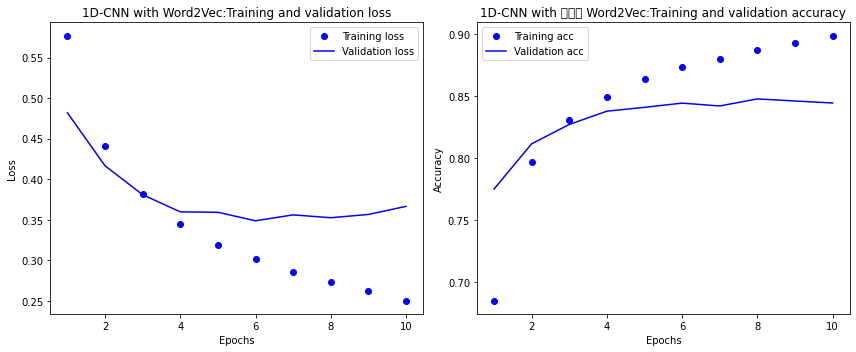

In [56]:
# 그래프 비교 
# 데이터 준비
acc4 = history4.history['accuracy']
val_acc4 = history4.history['val_accuracy']
loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']

epochs4 = range(1, len(acc4) + 1)

# 서브플롯 생성

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열의 서브플롯 생성, 크기 조정

# 첫 번째 서브플롯: Training and validation loss
axs[0].plot(epochs4, loss4, 'bo', label='Training loss')
axs[0].plot(epochs4, val_loss4, 'b', label='Validation loss')
axs[0].set_title('1D-CNN with Word2Vec:Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# 두 번째 서브플롯: Training and validation accuracy
axs[1].plot(epochs4, acc4, 'bo', label='Training acc')
axs[1].plot(epochs4, val_acc4, 'b', label='Validation acc')
axs[1].set_title('1D-CNN with 한국어 Word2Vec:Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

### 한국어 Word2Vec이 임베딩된 상태에서 LSTM

In [65]:
from keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
def model_build():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim, 
                                    embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                    input_length=maxlen, 
                                    trainable=True))   # trainable을 True로 주면 Fine-tuning
    model.add(tf.keras.layers.LSTM(16,dropout=0.2,recurrent_dropout=0.2))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

model = model_build()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                7488      
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 1,007,633
Trainable params: 1,007,633
Non-trainable params: 0
_________________________________________________________________


In [66]:
# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

# 모델 학습
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 44s 157ms/step - loss: 0.6469 - accuracy: 0.6045 - val_loss: 0.5186 - val_accuracy: 0.7524
Epoch 2/20
266/266 [==============================] - 41s 155ms/step - loss: 0.4862 - accuracy: 0.7717 - val_loss: 0.4228 - val_accuracy: 0.8103
Epoch 3/20
266/266 [==============================] - 41s 155ms/step - loss: 0.4235 - accuracy: 0.8082 - val_loss: 0.3849 - val_accuracy: 0.8282
Epoch 4/20
266/266 [==============================] - 41s 154ms/step - loss: 0.3908 - accuracy: 0.8260 - val_loss: 0.3645 - val_accuracy: 0.8427
Epoch 5/20
266/266 [==============================] - 41s 156ms/step - loss: 0.3724 - accuracy: 0.8356 - val_loss: 0.3568 - val_accuracy: 0.8433
Epoch 6/20
266/266 [==============================] - 41s 155ms/step - loss: 0.3566 - accuracy: 0.8444 - val_loss: 0.3492 - val_accuracy: 0.8501
Epoch 7/20
266/266 [==============================] - 41s 155ms/step - loss: 0.3449 - accuracy: 0.8499 - val_loss: 0.3425 - val_ac

In [67]:
# 평가
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

# 학습 결과 출력
history_dict = history.history
print(history_dict.keys())  # epoch에 따른 그래프를 그릴 수 있는 항목들

1537/1537 - 17s - loss: 0.3385 - accuracy: 0.8562
[0.3384877145290375, 0.85621577501297]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


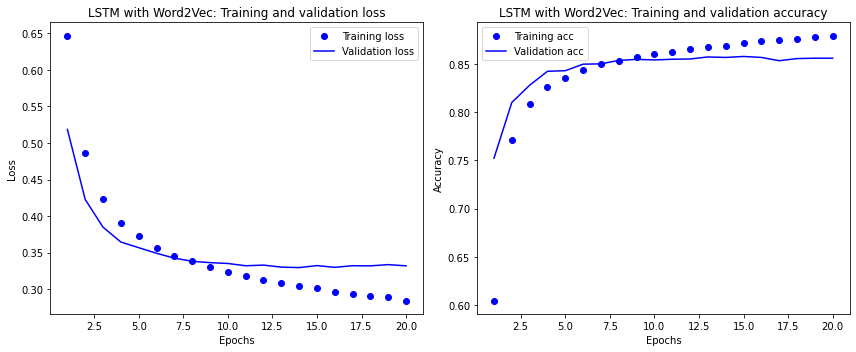

In [68]:
# 그래프 비교 
# 데이터 준비
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 서브플롯 생성

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열의 서브플롯 생성, 크기 조정

# 첫 번째 서브플롯: Training and validation loss
axs[0].plot(epochs, loss, 'bo', label='Training loss')
axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0].set_title('LSTM with Word2Vec: Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# 두 번째 서브플롯: Training and validation accuracy
axs[1].plot(epochs, acc, 'bo', label='Training acc')
axs[1].plot(epochs, val_acc, 'b', label='Validation acc')
axs[1].set_title('LSTM with Word2Vec: Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

### 한국어 Word2Vec을 임베딩하여 GlobalMaxPooling1D

In [62]:
# 하이퍼파라미터 설정
vocab_size = 10000      # 어휘 사전 크기
word_vector_dim = 100   # 워드 벡터 차원 (예시로 300으로 설정)
max_sequence_length = 41  # 시퀀스 최대 길이 (예시로 41로 설정)



# 모델 설계 - GlobalMaxPooling1D를 사용한 모델
model6 = tf.keras.Sequential([
    # Embedding 레이어: 사전 학습된 임베딩 매트릭스를 사용하여 초기화
    tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=word_vector_dim,
                              embeddings_initializer=Constant(embedding_matrix), # 여기서 embedding_matrix를 사용
                              input_length=max_sequence_length,
                              trainable=True),  # 학습되지 않도록 설정 (사전 학습된 값 고정)
    
    # GlobalMaxPooling1D 레이어
    tf.keras.layers.GlobalMaxPooling1D(),  # 시퀀스에서 최대값을 추출
    
    # Dense 레이어 (은닉층)
    tf.keras.layers.Dense(16, activation='relu'),
    
    # 출력층
    tf.keras.layers.Dense(1, activation='sigmoid')  # 긍정(1)과 부정(0) 분류
])

# 모델 요약
model6.summary()

# 모델 컴파일
model6.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 학습 (여기서는 예시 데이터 사용)
# X_train과 y_train은 훈련 데이터와 레이블
history6 = model6.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# 학습 결과 출력
history_dict6 = history6.history
print(history_dict6.keys())  # epoch에 따른 그래프를 그릴 수 있는 항목들

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 17        
Total params: 1,001,633
Trainable params: 1,001,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
4569/4569 [==============================] - 14s 3ms/step - loss: 0.5946 - accuracy: 0.6829 - val_loss: 0.5287 - val_accuracy: 0.7359
Epoch 2/10
4569/4569 [==============================] - 14s 3ms/step - loss: 0.4805 - accuracy: 0

In [63]:
# 모델 평가
results6 = model6.evaluate(X_test, y_test, verbose=2)
print(results6)

1537/1537 - 2s - loss: 0.3924 - accuracy: 0.8262
[0.39242759346961975, 0.8261691927909851]


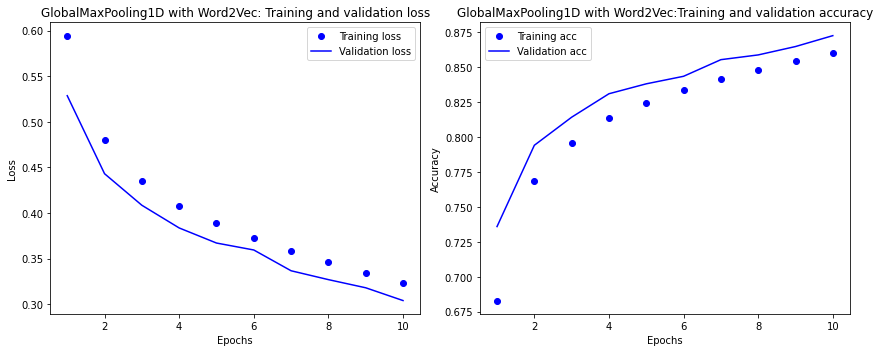

In [64]:
# 데이터 준비
acc6 = history_dict6['accuracy']
val_acc6 = history_dict6['val_accuracy']
loss6 = history_dict6['loss']
val_loss6 = history_dict6['val_loss']

epochs6 = range(1, len(acc6) + 1)

# 서브플롯 생성

fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1행 2열의 서브플롯 생성, 크기 조정

# 첫 번째 서브플롯: Training and validation loss
axs[0].plot(epochs6, loss6, 'bo', label='Training loss')
axs[0].plot(epochs6, val_loss6, 'b', label='Validation loss')
axs[0].set_title('GlobalMaxPooling1D with Word2Vec: Training and validation loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# 두 번째 서브플롯: Training and validation accuracy
axs[1].plot(epochs6, acc6, 'bo', label='Training acc')
axs[1].plot(epochs6, val_acc6, 'b', label='Validation acc')
axs[1].set_title('GlobalMaxPooling1D with Word2Vec:Training and validation accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

### 결론: 사전 학습된 임베딩을 통해 LSTM모델이 정확도 85%이상을 달성할수 있었다.

### 회고
여러번 모델을 학습시킬때 앞서 학습했던 정보가 계속 남아있지 않게 설정을 해줬어야 했는데
초반에 그러지 못해 결과가 훈련을 할수록 정확도가 낮아지게 나왔다. 그리고 0.5 근처의 정확도를 달성했었다.
앞으로는 이런부분을 잘 처리할수있도록 꼭 기억해둬야겠다.
그리고 트랜스포머 모델에 대해 좀더 공부를 해봐야겠지만, 이번 감성분석에서는 85%를 넘는 정확도는 달성하지 못했다.
그보다 LSTM이 좋은 결과를 내주어서 무조건 트랜스포머가 항상 최적의 모델이라고 할수는 없다는걸 실험하며 알게되었다.